In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set(style="white")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.unicode_minus"] = False

In [2]:
weather = pd.read_csv("./data/4183597.csv")
tour = pd.read_excel("./data/tourist juneau.xlsx")
co2 = pd.read_csv("./data/co2_annmean_mlo.csv", comment="#")

co2

,year,mean,unc
0,1959,315.98,0.12
1,1960,316.91,0.12
2,1961,317.64,0.12
3,1962,318.45,0.12
4,1963,318.99,0.12
...,...,...,...
61,2020,414.21,0.12
62,2021,416.41,0.12
63,2022,418.53,0.12
64,2023,421.08,0.12


In [3]:
tour_year = tour['年份'].astype(int).to_numpy()
tour_x0 = tour['游客数量（人）'].astype(float).to_numpy()

mask_non_pandemic = (tour_year != 2020) & (tour_year != 2021)

tour_year_np = tour_year[mask_non_pandemic]
tour_x0_np = tour_x0[mask_non_pandemic]

tour_x0_million_np = tour_x0_np / 1e6

In [4]:
wx_station = weather[weather["STATION"] == "USW00025309"][["DATE", "TAVG"]].copy()

wx_year = wx_station["DATE"].astype(int).to_numpy()
wx_Tavg_F = wx_station["TAVG"].astype(float).to_numpy()
wx_Tavg_C = (wx_Tavg_F - 32.0) * (5.0 / 9.0)

wx_map = {int(y): float(t) for y, t in zip(wx_year, wx_Tavg_C)}
T_np = np.array([wx_map[int(y)] for y in tour_year_np], dtype=float)

In [6]:
co2_year = co2["year"].astype(int).to_numpy()
co2_mean = co2["mean"].astype(float).to_numpy()
co2_map = {int(y): float(v) for y, v in zip(co2_year, co2_mean)}

C_np = np.array([co2_map[int(y)] for y in tour_year_np], dtype=float)


In [ ]:
from scipy.optimize import curve_fit

tour_x0 = tour.query("年份 in @tour_year_np")['游客数量（人）'].astype(float).to_numpy()
tour_x0_million = tour_x0 / 1e6  

def log_model(x, a, b, c):
    x = np.asarray(x, dtype=float)
    return a * np.log(b * x) + c

p0 = (1.0, 1e-3, 5.0)

popt, _ = curve_fit(log_model, tour_x0_million, T_np, p0=p0, maxfev=10000)
a_eq4, b_eq4, c_eq4 = popt

def T_of_x0_million(x0_million):
    x0_million = np.asarray(x0_million, dtype=float)
    return log_model(x0_million, a_eq4, b_eq4, c_eq4)


In [ ]:

alpha_C, beta_C, gamma_C = np.polyfit(tour_x0_million, C_np, deg=2)

def C_of_x0_million(x0_million):
    x0_million = np.asarray(x0_million, dtype=float)
    return alpha_C * x0_million**2 + beta_C * x0_million + gamma_C

x_grid = np.linspace(tour_x0_million.min(), tour_x0_million.max(), 500)
T_grid = T_of_x0_million(x_grid)
C_grid = C_of_x0_million(x_grid)

Tmin, Tmax = T_grid.min(), T_grid.max()
Cmin, Cmax = C_grid.min(), C_grid.max()

Tmin, Tmax, Cmin, Cmax

(6.316642469040589, 6.5382793975413005, 400.1312967951004, 420.7131367557448)

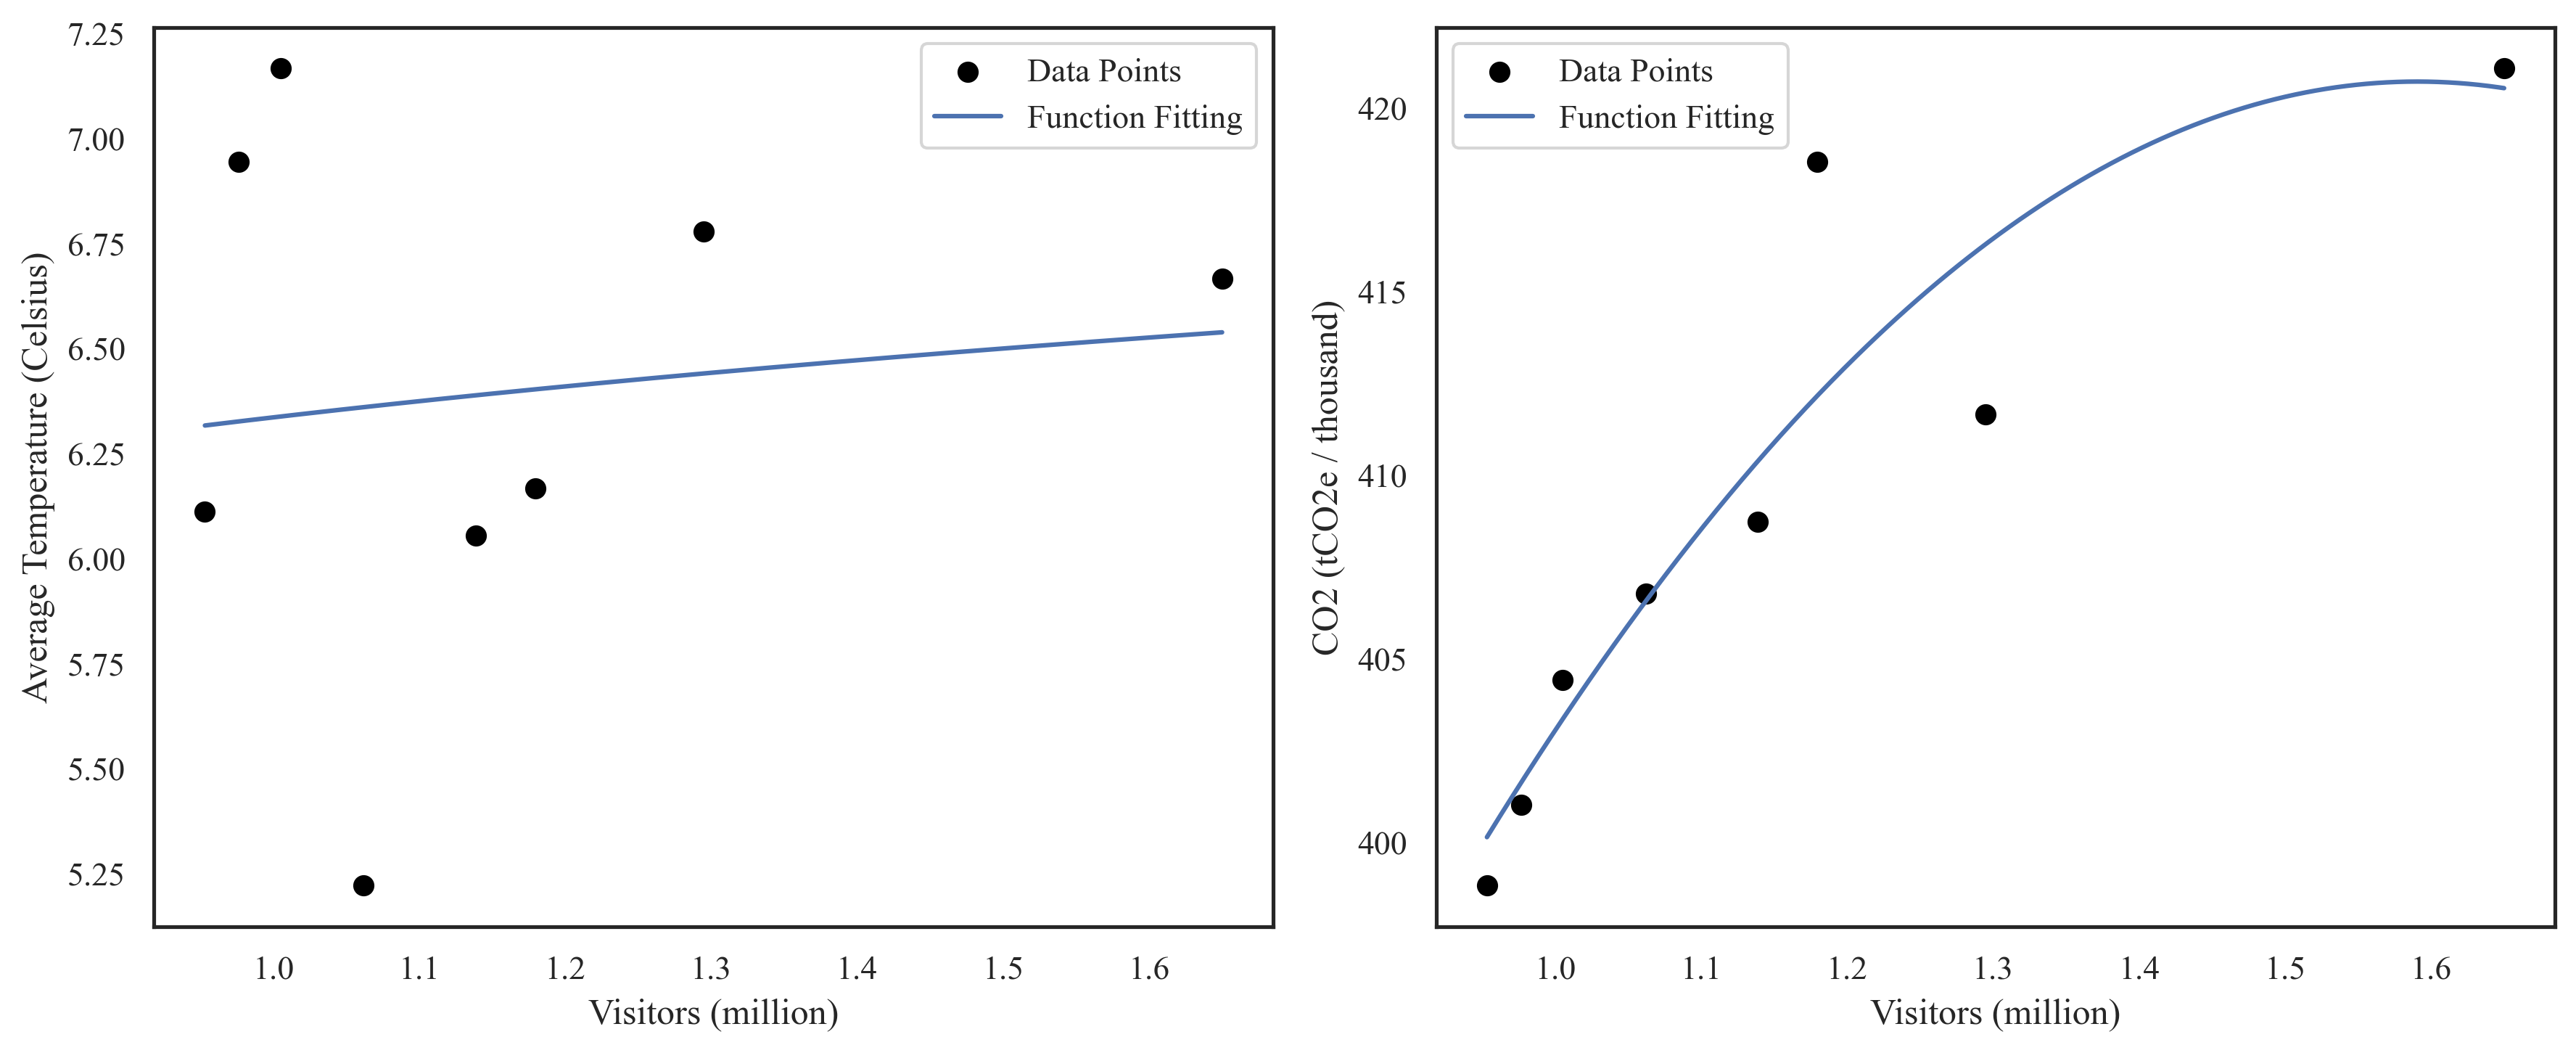

In [ ]:

x_plot_m = np.linspace(np.min(tour_x0_million_np), np.max(tour_x0_million_np), 400)

plt.figure(figsize=(12, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.scatter(tour_x0_million_np, T_np, color='black', label="Data Points")
plt.plot(x_plot_m, T_of_x0_million(x_plot_m), label="Function Fitting")
plt.xlabel("Visitors (million)")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(tour_x0_million_np, C_np, color='black', label="Data Points")
plt.plot(x_plot_m, C_of_x0_million(x_plot_m), label="Function Fitting")
plt.xlabel("Visitors (million)")
plt.ylabel("CO2 (tCO2e / thousand)")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

s_income = 0.64
s_congestion = 0.44
s_infra = 0.20

scores = np.array([s_income, s_congestion, s_infra])

A = np.zeros((3, 3), dtype=float)
for i in range(3):
    for j in range(3):
        A[i, j] = scores[i] / scores[j]

A.round(2)


array([[1.  , 1.45, 3.2 ],
       [0.69, 1.  , 2.2 ],
       [0.31, 0.45, 1.  ]])

In [ ]:

col_sum = A.sum(axis=0)
A_norm = A / col_sum

w = A_norm.mean(axis=1)
w = w / w.sum() 

w_income, w_cong, w_infra = w  # 分别是：居民收入、城市拥堵、基础设施压力

print(w)

n = A.shape[0]
lambda_max = np.dot(col_sum, w) 
CI = (lambda_max - n) / (n - 1)

RI = 0.52
CR = CI / RI

print(f"\nlambda_max = {lambda_max:.4f}")
print(f"CI = {CI:.4f}")
print(f"CR = {CR:.4f}")


[0.5     0.34375 0.15625]

lambda_max = 3.0000
CI = 0.0000
CR = 0.0000


In [ ]:

mask_2023 = (tour['年份'].astype(int) == 2023)

x0_2023_persons = float(tour.loc[mask_2023, '游客数量（人）'].iloc[0])
x0_2023_million = x0_2023_persons / 1e6  

S_2023 = 300.0 
G_2023 = 10170.0 
P_j   = 31700.0  

RS_2023 = 68.0     
t0 = 243.0   

waste_local   = 2.2 
waste_tourist = 2.8 

In [ ]:

w_income = 0.5
w_cong   = 0.34
w_infra  = 0.16

def rs_components(x0_m, dt, S, G):
    x0_persons      = float(x0_m) * 1e6
    x0_base_persons = x0_2023_persons

    income_current = (t0 + dt) * x0_persons
    income_base    = t0 * x0_base_persons
    income_idx     = income_current / income_base

    road_per_current = S / x0_persons
    road_per_base    = S_2023 / x0_base_persons
    cong_idx         = road_per_current / road_per_base

    waste_base    = waste_tourist * x0_base_persons + waste_local * P_j
    waste_current = waste_tourist * x0_persons      + waste_local * P_j
    infra_idx = (G / waste_current) / (G_2023 / waste_base)

    return income_idx, cong_idx, infra_idx

def RS_raw(x0_m, dt, S, G):
    income_idx, cong_idx, infra_idx = rs_components(x0_m, dt, S, G)
    composite_idx = (
        w_income * income_idx +
        w_cong   * cong_idx +
        w_infra  * infra_idx
    )
    return RS_2023 * composite_idx



In [ ]:
base_year = 2023
mask_base = (tour['年份'].astype(int) == base_year)

x0_base_persons = float(tour.loc[mask_base, '游客数量（人）'].iloc[0])
x0_base_million = x0_base_persons / 1e6

ELAS_CONS = -0.72 
t0 = 243.0 
beta0_eq14 = np.log(x0_base_million) - ELAS_CONS * np.log(t0)

def ln_x_million_from_t(t):
    t = np.asarray(t, dtype=float)
    return ELAS_CONS * np.log(t) + beta0_eq14

def x_from_t_million(t):
    ln_x = ln_x_million_from_t(t)
    return np.exp(ln_x)

def ln_x_million_from_policy(delta_t, delta_r):
    t_eff = t0 + delta_t + 174.0 * delta_r
    return ELAS_CONS * np.log(t_eff) + beta0_eq14

def x_from_policy_million(delta_t, delta_r):
    ln_x = ln_x_million_from_policy(delta_t, delta_r)
    return np.exp(ln_x)


In [ ]:

def constraint_eq9_visitors_balance(x1_m, x2_m, x3_m, x0_m):
    return x1_m + x2_m + x3_m - x0_m 

def constraint_eq14_15(x0_m, delta_t, delta_r):
    x_pred_m = x_from_policy_million(delta_t, delta_r)
    return float(x0_m) - float(x_pred_m)

T_threshold = 0.5 * (Tmax + Tmin)
C_threshold = 0.5 * (Cmax + Cmin)

def constraint_eq16_T(x0_m):
    return T_of_x0_million(float(x0_m)) - T_threshold   # <= 0

def constraint_eq17_C(x0_m):
    return C_of_x0_million(float(x0_m)) - C_threshold   # <= 0

# Eq.(18) 垃圾约束
def constraint_eq18_waste(x0_m, G):
    x0_persons = float(x0_m) * 1e6
    total_waste = waste_tourist * x0_persons + waste_local * P_j
    return total_waste / float(G) - 1.0   # <= 0


In [ ]:
t1, t2, t3 = 239.0, 189.0, 160.0   # 三景点人均消费
k_hotel    = 179.0
r0         = 0.09

def FR(x1_m, x2_m, x3_m, x0_m, delta_t, delta_r):
    x_vec_persons = np.array([x1_m, x2_m, x3_m], dtype=float) * 1e6
    x0_persons    = float(x0_m) * 1e6

    t = np.array([t1, t2, t3], dtype=float)

    attraction_income = np.sum(x_vec_persons * (t + delta_t))
    hotel_income      = x0_persons * k_hotel * (r0 + delta_r)

    return attraction_income + hotel_income 


In [17]:
w_T = 0.7
w_C = 0.3

def ED(x0_m):
    """
    x0_m：百万人/年
    ED = w_T * T(x0)/Tmin + w_C * C(x0)/Cmin  （Eq.(6)）
    """
    T_val = T_of_x0_million(float(x0_m))
    C_val = C_of_x0_million(float(x0_m))
    return w_T * (T_val / Tmin) + w_C * (C_val / Cmin)


In [ ]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

class JuneauTourismProblem(ElementwiseProblem):
    def __init__(self):
        xl = np.array([
            0.0,
            0.0,
            0.0,
            0.8,
            0.0,
            0.0,
            S_2023,
            G_2023 
        ], dtype=float)

        xu = np.array([
            1.6,
            0.6,
            0.6,
            1.9, 
            100.0,
            0.10,
            500.0,
            3.0e6  
        ], dtype=float)

        super().__init__(n_var=8, n_obj=3, n_constr=5, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        x1, x2, x3, x0_m, dt, dr, S, G = x

        FR_val = FR(x1, x2, x3, x0_m, dt, dr)   # USD
        ED_val = ED(x0_m)                       # 1~8
        RS_val = RS_raw(x0_m, dt, S, G)         # ~ 50~80

        TR_obj = -FR_val
        RS_obj = -RS_val
        f1, f2, f3 = TR_obj, ED_val, RS_obj

        eps_eq = 1e-3

        g1 = np.abs(constraint_eq9_visitors_balance(x1, x2, x3, x0_m)) - eps_eq
        g2 = np.abs(constraint_eq14_15(x0_m, dt, dr)) - eps_eq
        g3 = constraint_eq16_T(x0_m)
        g4 = constraint_eq17_C(x0_m)
        g5 = constraint_eq18_waste(x0_m, G)

        out["F"] = np.array([f1, f2, f3])
        out["G"] = np.array([g1, g2, g3, g4, g5])

problem = JuneauTourismProblem()
algorithm = NSGA2(pop_size=300)
termination = get_termination("n_gen", 300)

res = minimize(problem, algorithm, termination, seed=42, verbose=False)

pop   = res.pop
F_pop = pop.get("F")
G_pop = pop.get("G")
X_pop = pop.get("X")

CV = np.maximum(G_pop, 0.0).sum(axis=1)
feasible_idx = np.where(CV <= 1e-2)[0]
if feasible_idx.size == 0:
    k = min(255, len(CV))
    feasible_idx = np.argsort(CV)[:k]

F_pf = F_pop[feasible_idx]
X_pf = X_pop[feasible_idx]

TR_vals = F_pf[:, 0]
ED_vals = F_pf[:, 1]
RS_vals = F_pf[:, 2]
idx_best_TR = np.argmin(TR_vals)
idx_best_ED = np.argmin(ED_vals)
idx_best_RS = np.argmin(RS_vals)

sel_idx = np.unique([idx_best_TR, idx_best_ED, idx_best_RS])

sel_X      = X_pf[sel_idx]
sel_TR     = TR_vals[sel_idx]
sel_ED     = ED_vals[sel_idx]
sel_RS     = RS_vals[sel_idx]

result_df = pd.DataFrame(
    np.column_stack([sel_X, sel_TR, sel_ED, sel_RS]),
    columns=["x1", "x2", "x3", "x0", "Δt", "Δr", "S", "G", "TR", "ED", "RS"]
)


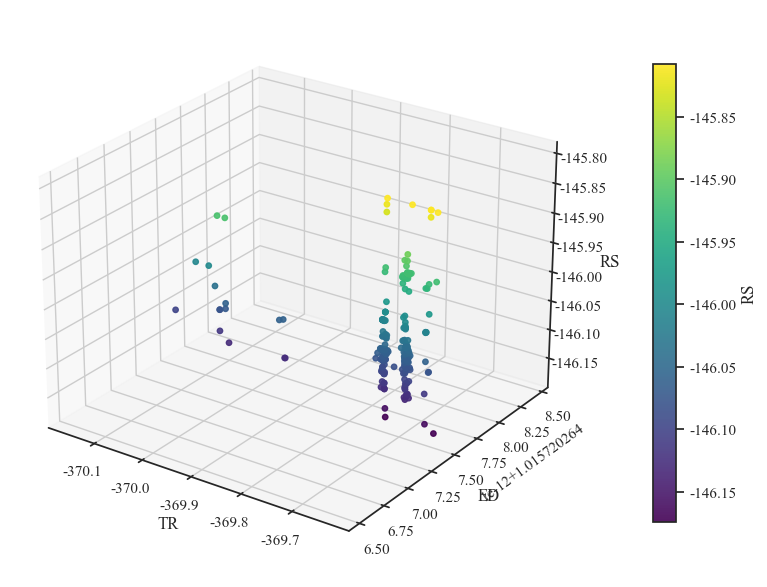

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(TR_vals, ED_vals, RS_vals, c=RS_vals, s=15, alpha=0.9, cmap='viridis')
ax.set_xlabel("TR")
ax.set_ylabel("ED")
ax.set_zlabel("RS")
ax.view_init(elev=25, azim=-55)
cb = fig.colorbar(sc, ax=ax, pad=0.1, shrink=0.6)
cb.set_label("RS")
plt.tight_layout()
plt.show()

In [ ]:

base = result_df.iloc[0]
x_base = base[["x1", "x2", "x3", "x0", "Δt", "Δr", "S", "G"]].to_numpy(dtype=float)

var_names = ["x1", "x2", "x3", "x0", "Δt", "Δr", "S", "G"]
obj_names = ["FR", "ED", "RS"]
n_var = len(var_names)
n_obj = len(obj_names)

for name, val in zip(var_names, x_base):
    print(f"  {name} = {val:.4f}")


n_samples = 21 
corr_mat = np.zeros((n_var, n_obj), dtype=float)

def safe_corr(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if np.allclose(a, a[0]) or np.allclose(b, b[0]):
        return 0.0
    return float(np.corrcoef(a, b)[0, 1])

for j in range(n_var):
    x0_val = float(x_base[j])
    low = 0.9 * x0_val
    high = 1.1 * x0_val
    grid = np.linspace(low, high, n_samples)

    FR_list = []
    ED_list = []
    RS_list = []

    for val in grid:
        x = x_base.copy()
        x[j] = val
        x1, x2, x3, x0_m, dt, dr, S, G = x

        fr_val = FR(x1, x2, x3, x0_m, dt, dr)      # 财政收入
        ed_val = ED(x0_m)                          # 环境损害
        rs_val = RS_raw(x0_m, dt, S, G)            # 居民满意度

        FR_list.append(fr_val)
        ED_list.append(ed_val)
        RS_list.append(rs_val)

    X_arr  = grid
    FR_arr = np.array(FR_list)
    ED_arr = np.array(ED_list)
    RS_arr = np.array(RS_list)

    corr_mat[j, 0] = safe_corr(X_arr, FR_arr)
    corr_mat[j, 1] = safe_corr(X_arr, ED_arr)
    corr_mat[j, 2] = safe_corr(X_arr, RS_arr)

corr_df = pd.DataFrame(corr_mat, index=var_names, columns=obj_names)
juneau_df = corr_df.copy()
corr_df


  x1 = 0.3000
  x2 = 0.3817
  x3 = 0.4575
  x0 = 1.1397
  Δt = 100.0000
  Δr = 0.1000
  S = 450.6630
  G = 3000000.0000


,FR,ED,RS
x1,1.0,0.000000,0.00000
x2,1.0,0.000000,0.00000
x3,1.0,0.000000,0.00000
x0,1.0,0.998934,-0.99858
Δt,1.0,0.000000,1.00000
Δr,1.0,0.000000,0.00000
S,0.0,0.000000,1.00000
G,0.0,0.000000,1.00000


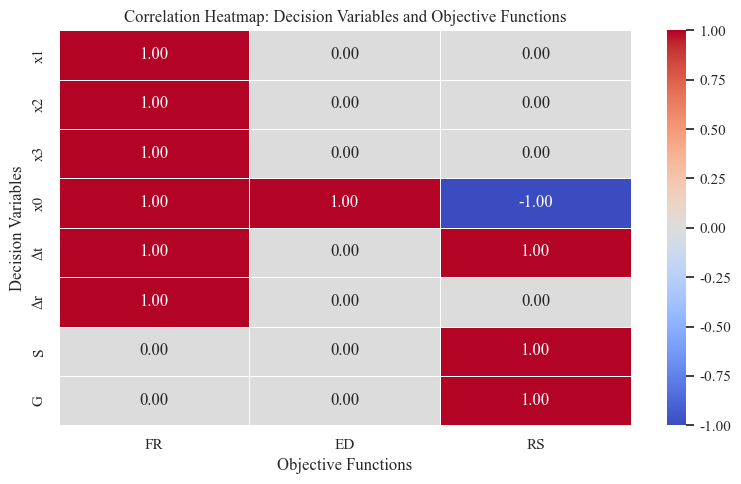

In [ ]:


plt.figure(figsize=(8, 5))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1, center=0,
    linewidths=0.5,
)

plt.title("Correlation Heatmap: Decision Variables and Objective Functions")
plt.xlabel("Objective Functions")
plt.ylabel("Decision Variables")
plt.tight_layout()
plt.show()


In [23]:
mdv_raw = pd.read_csv("./data/Total+tourist+arrivals.csv", skiprows=7)

col_date = mdv_raw.columns[0]
col_val  = mdv_raw.columns[1]
mdv_monthly = mdv_raw.dropna(how="any")
mdv_monthly["Date"] = pd.to_datetime(mdv_monthly["Date"], format="%d/%m/%Y", errors="coerce")
mdv_monthly["Amount"] = pd.to_numeric(mdv_monthly["Amount"], errors="coerce") / 1e6
mdv_monthly = mdv_monthly.dropna(subset=["Date", "Amount"])

mdv_monthly["Year"] = mdv_monthly["Date"].dt.year
mdv_monthly["Month"] = mdv_monthly["Date"].dt.month
mdv_monthly

,Date,Amount,Year,Month
0,1988-01-31,0.016410,1988,1
1,1988-02-29,0.017318,1988,2
2,1988-03-31,0.016871,1988,3
3,1988-04-30,0.012562,1988,4
4,1988-05-31,0.008841,1988,5
...,...,...,...,...
449,2025-06-30,0.141772,2025,6
450,2025-07-31,0.186738,2025,7
451,2025-08-31,0.192058,2025,8
452,2025-09-30,0.149563,2025,9


In [24]:
last_10_years = list(range(2014, 2024))
last_10_years.remove(2020)
last_10_years.remove(2021)
mdv_annual_last10 = (
    mdv_monthly[mdv_monthly["Year"].isin(last_10_years)]
    .groupby("Year", as_index=False)["Amount"]
    .sum()
    .rename(columns={"Amount": "TotalArrivals"})
)

mdv_annual_last10


,Year,TotalArrivals
0,2014,1.204857
1,2015,1.234248
2,2016,1.286135
3,2017,1.389542
4,2018,1.484274
5,2019,1.702887
6,2022,1.675303
7,2023,1.878543


In [25]:
popt, _ = curve_fit(log_model, mdv_annual_last10['TotalArrivals'], T_np, p0=p0, maxfev=10000)
a_eq, b_eq, c_eq = popt

def T_of_x0_million(x0_million):
    x0_million = np.asarray(x0_million, dtype=float)
    return log_model(x0_million, a_eq, b_eq, c_eq)


alpha_C, beta_C, gamma_C = np.polyfit(mdv_annual_last10['TotalArrivals'], C_np, deg=2)

def C_of_x0_million(x0_million):
    x0_million = np.asarray(x0_million, dtype=float)
    return alpha_C * x0_million**2 + beta_C * x0_million + gamma_C

x_grid = np.linspace(tour_x0_million.min(), tour_x0_million.max(), 500)
T_grid = T_of_x0_million(x_grid)
C_grid = C_of_x0_million(x_grid)

Tmin, Tmax = T_grid.min(), T_grid.max()
Cmin, Cmax = C_grid.min(), C_grid.max()

Tmin, Tmax, Cmin, Cmax

(6.3596780775589075, 6.39700676287968, 390.3638356693853, 414.35371801446956)

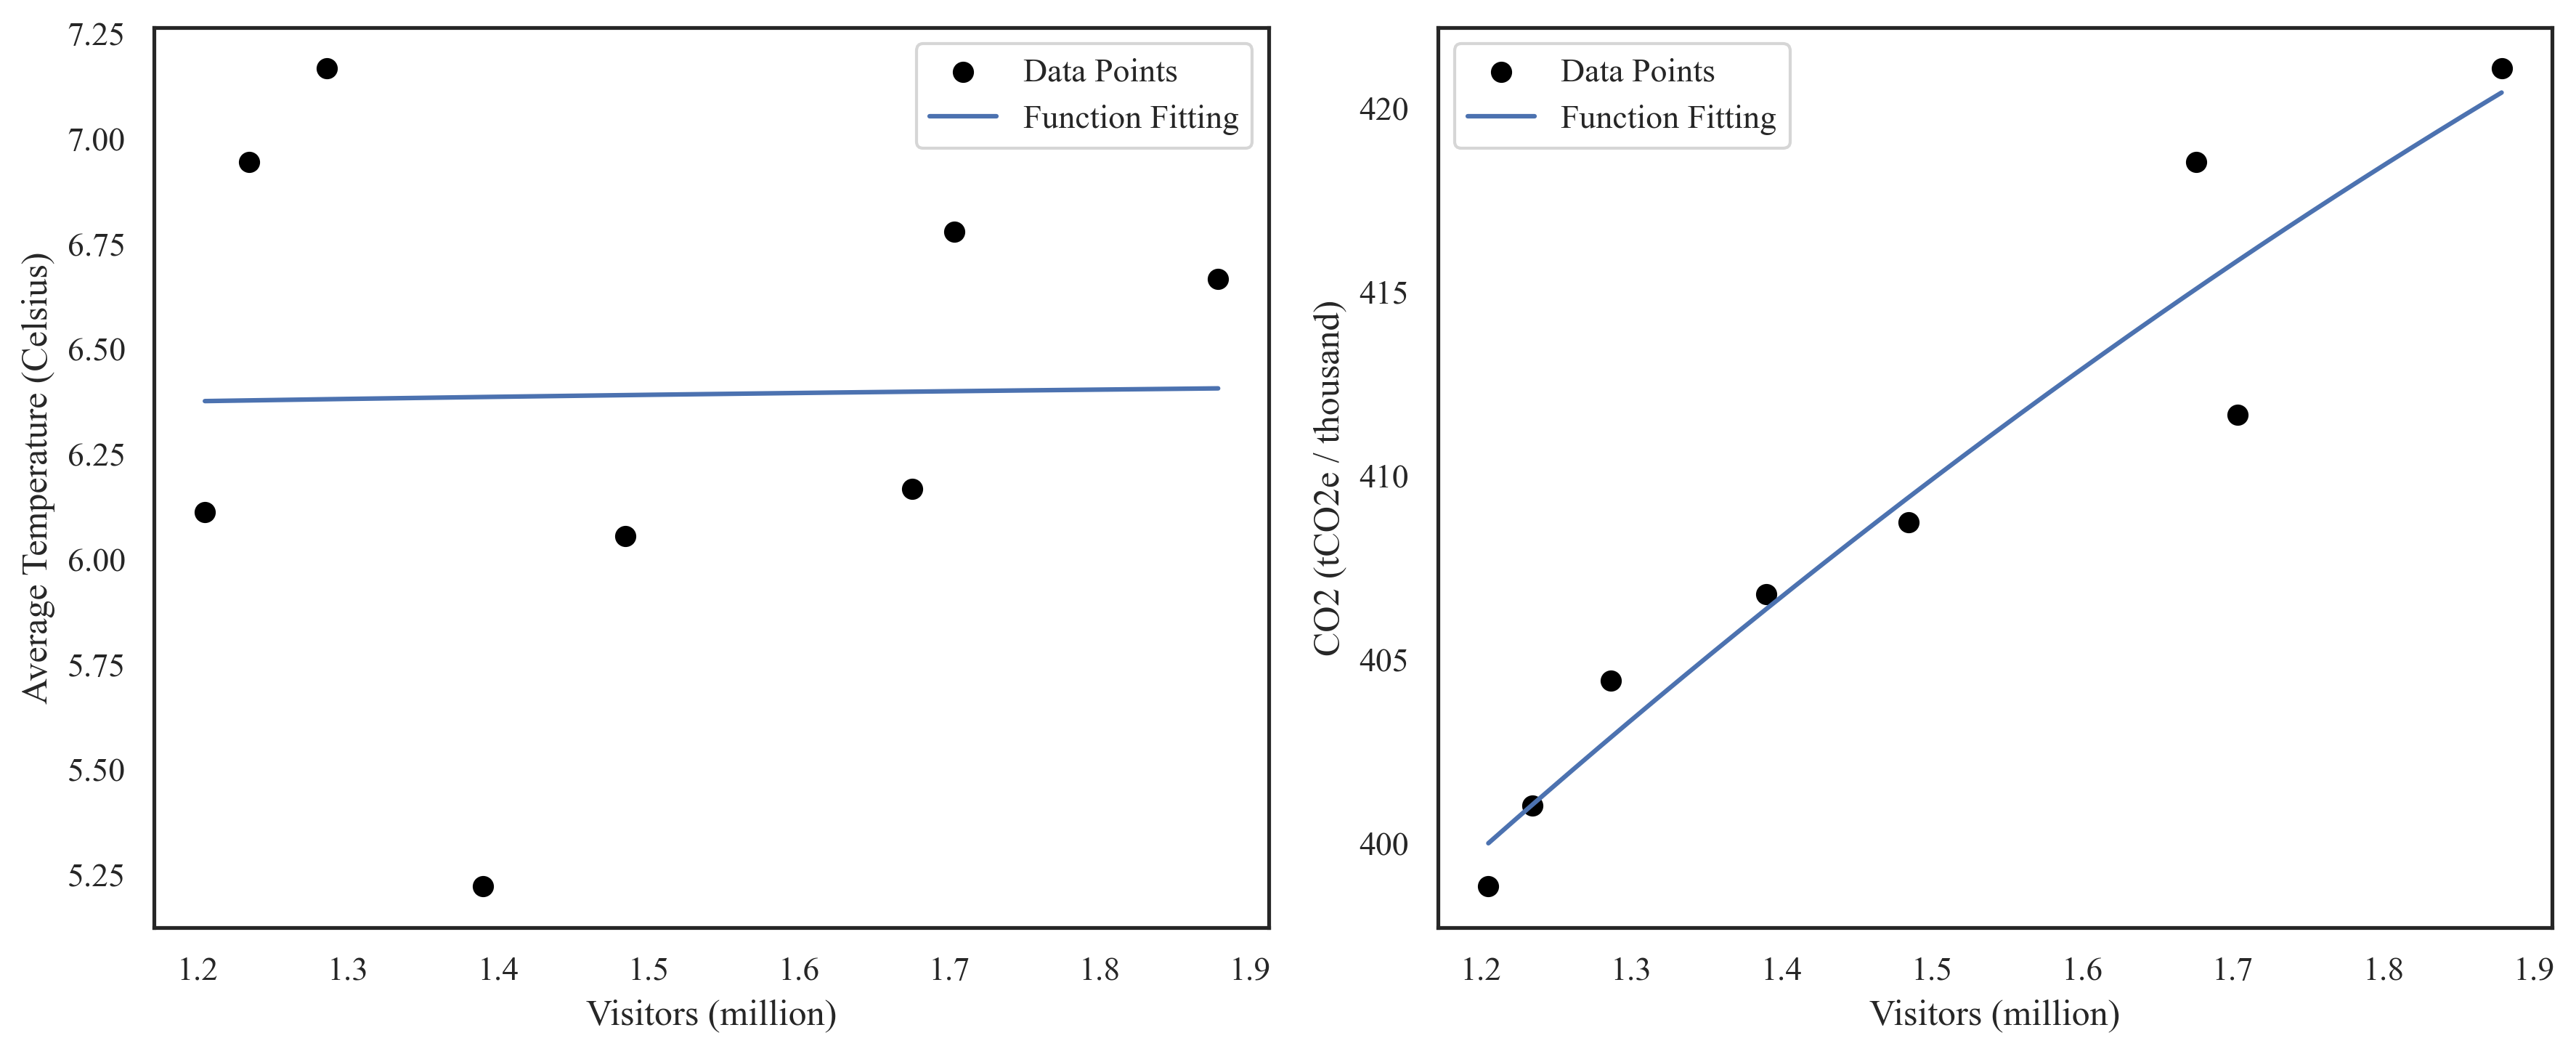

In [ ]:

x_plot_m = np.linspace(np.min(mdv_annual_last10['TotalArrivals']), np.max(mdv_annual_last10['TotalArrivals']), 400)

plt.figure(figsize=(12, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.scatter(mdv_annual_last10['TotalArrivals'], T_np, color='black', label="Data Points")
plt.plot(x_plot_m, T_of_x0_million(x_plot_m), label="Function Fitting")
plt.xlabel("Visitors (million)")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()
                       
plt.subplot(1, 2, 2)
plt.scatter(mdv_annual_last10['TotalArrivals'], C_np, color='black', label="Data Points")
plt.plot(x_plot_m, C_of_x0_million(x_plot_m), label="Function Fitting")
plt.xlabel("Visitors (million)")
plt.ylabel("CO2 (tCO2e / thousand)")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
year_ref_mdv = int(mdv_annual_last10["Year"].max())
x0_MDV_2023_persons = float(
    mdv_annual_last10.iloc[-1]['TotalArrivals']
)

t0_MDV = 351.0                 # 平均每日人均消费 USD/人·天
t1_MDV, t2_MDV, t3_MDV = 800.0, 250.0, 300.0  # 三类旅游活动人均消费（大概值）

k_hotel_MDV = 115.6            # 酒店人均价格 USD/人·天
r0_MDV      = 0.12             # 酒店基本税率 12%   

P_j_MDV           = 521_400.0  # 常住人口
waste_local_MDV   = 2.8        # 居民日均垃圾 kg/人·天
waste_tourist_MDV = 3.5        # 游客日均垃圾 kg/人·天
G_MDV_2023        = 9_612_420.0  # 垃圾处理能力 kg/day（基准）

S_MDV_2023  = 300.0  
RS_MDV_2023 = 68.0

In [28]:
t0_MDV * x0_MDV_2023_persons / w_income

1318.737186

In [29]:
def ED(x0):
    return 0.3 * T_of_x0_million(x0) / Tmin + 0.7 * C_of_x0_million(x0) / Cmin

def RS(x0, dt, s, g):
    return w_income * (t0_MDV + dt) * x0 / (t0_MDV * x0_MDV_2023_persons) + w_cong * (s / x0) / (S_MDV_2023 / x0_MDV_2023_persons) + w_infra * (g / (waste_tourist_MDV * x0 + waste_local_MDV * P_j_MDV)) / (G_MDV_2023 / (waste_tourist_MDV * x0_MDV_2023_persons + waste_local_MDV * P_j_MDV))

def FR(x1, x2, x3, x0, dt, dr):
    attraction_income = x1 * (t1_MDV + dt) + x2 * (t2_MDV + dt) + x3 * (t3_MDV + dt)
    hotel_income = x0 * k_hotel_MDV * (r0_MDV + dr)
    return attraction_income + hotel_income

In [ ]:
class JuneauTourismProblem(ElementwiseProblem):
    def __init__(self):
        xl = np.array([
            0.0,
            0.0,
            0.0,
            0.8,
            0.0,
            0.0,
            S_2023,
            G_2023
        ], dtype=float)

        xu = np.array([
            1.6,
            0.6,
            0.6,
            2,
            100.0,
            0.10,
            500.0,  
            3.0e6 
        ], dtype=float)

        super().__init__(n_var=8, n_obj=3, n_constr=5, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        x1, x2, x3, x0_m, dt, dr, S, G = x
        FR_val = FR(x1, x2, x3, x0_m, dt, dr)
        ED_val = ED(x0_m)                  
        RS_val = RS_raw(x0_m, dt, S, G)
        TR_obj = -FR_val
        RS_obj = -RS_val / 40.0

        f1, f2, f3 = TR_obj, ED_val, RS_obj
        eps_eq = 1e-3

        g1 = np.abs(constraint_eq9_visitors_balance(x1, x2, x3, x0_m)) - eps_eq
        g2 = np.abs(constraint_eq14_15(x0_m, dt, dr)) - eps_eq

        g3 = constraint_eq16_T(x0_m)
        g4 = constraint_eq17_C(x0_m)
        g5 = constraint_eq18_waste(x0_m, G)

        out["F"] = np.array([f1, f2, f3])
        out["G"] = np.array([g1, g2, g3, g4, g5])

problem = JuneauTourismProblem()
algorithm = NSGA2(pop_size=300)
termination = get_termination("n_gen", 300)

res = minimize(problem, algorithm, termination, seed=42, verbose=False)

pop   = res.pop
F_pop = pop.get("F") 
G_pop = pop.get("G")
X_pop = pop.get("X") 

CV = np.maximum(G_pop, 0.0).sum(axis=1)
feasible_idx = np.where(CV <= 1e-2)[0]
if feasible_idx.size == 0:
    k = min(255, len(CV))
    feasible_idx = np.argsort(CV)[:k]

F_pf = F_pop[feasible_idx] 
X_pf = X_pop[feasible_idx] 
TR_vals = F_pf[:, 0]
ED_vals = F_pf[:, 1]
RS_vals = F_pf[:, 2]

idx_best_TR = np.argmin(TR_vals)
idx_best_ED = np.argmin(ED_vals)
idx_best_RS = np.argmin(RS_vals)

sel_idx = np.unique([idx_best_TR, idx_best_ED, idx_best_RS])

sel_X      = X_pf[sel_idx]
sel_TR     = TR_vals[sel_idx]
sel_ED     = ED_vals[sel_idx]
sel_RS     = RS_vals[sel_idx]

result_df = pd.DataFrame(
    np.column_stack([sel_X, sel_TR, sel_ED, sel_RS]),
    columns=["x1", "x2", "x3", "x0", "Δt", "Δr", "S", "G", "TR", "ED", "RS"]
)
result_df


,x1,x2,x3,x0,Δt,Δr,S,G,TR,ED,RS
0,0.328054,0.386821,0.525945,1.241326,100.0,0.1,312.465377,3000000.0,-672.583866,1.020444,-134.273721
1,0.328053,0.386751,0.527332,1.241326,100.0,0.1,325.554883,3000000.0,-673.112502,1.020444,-134.303299
2,0.328055,0.387143,0.525886,1.241326,100.0,0.1,432.354071,3000000.0,-672.673371,1.020444,-134.544631


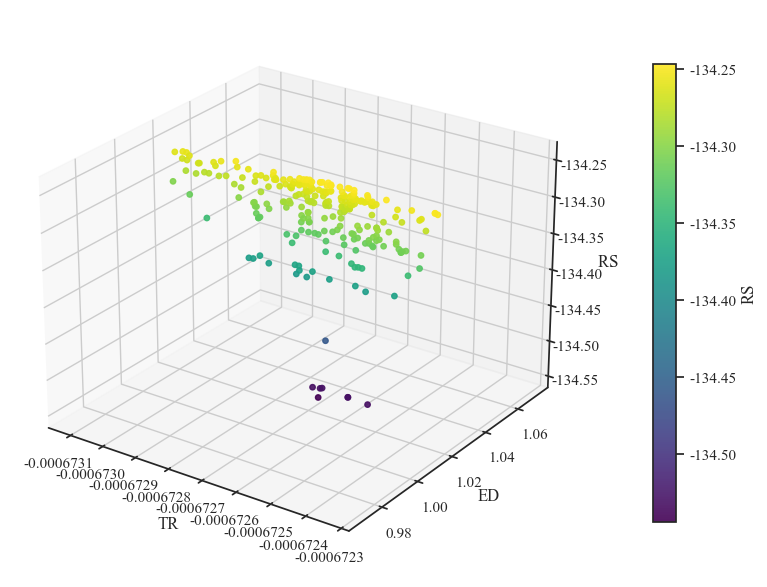

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    TR_vals, ED_vals, RS_vals,
    c=RS_vals, s=15, alpha=0.9, cmap='viridis'
)

ax.set_xlabel("TR")
ax.set_ylabel("ED")
ax.set_zlabel("RS ")

ax.view_init(elev=25, azim=-55)

cb = fig.colorbar(sc, ax=ax, pad=0.1, shrink=0.6)
cb.set_label("RS")

plt.tight_layout()
plt.show()
